# Object Detection using Sliding Window

We will be using concepts like Image Pyramid, Sliding Window and Non-Maxima Supression to turn almost any Image Classifier into an Object Detector
* **Image Pyramid**: 
  * An image pyramid is a multi-scale representation of an image, allowing us to find objects in images at different scales of an image.
  * At the bottom of the pyramid, we have the original image at its original size (in terms of width and height).
  * And at each subsequent layer, the image is resized (subsampled) and optionally smoothed (usually via Gaussian blurring).
  * The image is progressively subsampled until some stopping criterion is met, which is normally when a minimum size has been reached and no further subsampling needs to take place.
* **Sliding Window**:
  * A sliding window is a fixed-size rectangle that slides from left-to-right and top-to-bottom within an image.
  * At each stop of the window we would:
    * Extract the ROI
    * Pass it through our image classifier
    * Obtain the output predictions
* **Non-Maxima Supression**:
  * When performing object detection, our object detector will typically produce multiple, overlapping bounding boxes surrounding an object in an image.
  * We somehow need to collapse/remove the extraneous bounding boxes.
  * Non-maxima suppression (NMS) collapses weak, overlapping bounding boxes in favor of the more confident ones.
  
**Credits**: [PyImageSearch](https://pyimagesearch.com/2020/06/22/turning-any-cnn-image-classifier-into-an-object-detector-with-keras-tensorflow-and-opencv/)

In [1]:
!pip install imutils

  Preparing metadata (setup.py) ... - done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=91eeed7214f6527a4d4ec5ce5336efb4617f14be2738620ebc4418cc76f769bb
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


In [2]:
import numpy as np
import argparse
import imutils
import time
import cv2

import tensorflow as tf
from tensorflow.keras.models import load_model

from imutils.object_detection import non_max_suppression

import matplotlib.pyplot as plt

In [3]:
def sliding_window(image, step, ws):
    for y in range(0, image.shape[0] - ws[1], step):
        for x in range(0, image.shape[1] - ws[0], step):
            yield (x, y, image[y:y + ws[1], x:x + ws[0]])

def image_pyramid(image, scale=1.5, minSize=(28, 28)):
    yield image
    while True:
        w = int(image.shape[1] / scale)
        image = imutils.resize(image, width=w)
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        yield image            

In [4]:
PYR_SCALE = 1.25
WIN_STEP = 7
ROI_SIZE = (21, 21)
INPUT_SIZE = (28, 28)
VISUALIZE = False
MIN_CONF = 0.8

In [5]:
model = load_model('../input/mnist-net/mnist_net.h5')
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

2022-03-03 11:35:11.725360: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


11501568/11490434 [==============================] - 0s 0us/step


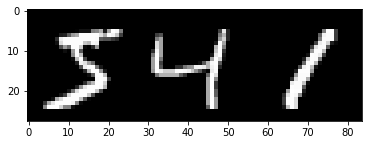

In [6]:
orig = np.zeros((28, 84))
orig[:, :28] = x_train[0]
orig[:, 28:56] = x_train[2]
orig[:, 56:] = x_train[3]
(H, W) = orig.shape[:2]
plt.imshow(orig, cmap='gray');

In [7]:
pyramid = image_pyramid(orig, scale=PYR_SCALE, minSize=ROI_SIZE)
rois = []
locs = []

In [8]:
for image in pyramid:
    scale = W / float(image.shape[1])
    for (x, y, roiOrig) in sliding_window(image, WIN_STEP, ROI_SIZE):
        x = int(x * scale)
        y = int(y * scale)
        w = int(ROI_SIZE[0] * scale)
        h = int(ROI_SIZE[1] * scale)

        roi = cv2.resize(roiOrig, INPUT_SIZE)

        rois.append(roi)
        locs.append((x, y, x + w, y + h))

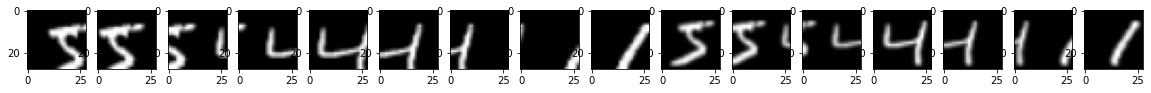

In [9]:
fig, axes = plt.subplots(1, len(rois), figsize=(20, 6))
for ax, roi in zip(axes, rois):
    ax.imshow(roi, cmap='gray')

In [10]:
rois = np.array(rois, dtype="float32")
preds = model.predict(rois)
preds = list(zip(preds.argmax(axis=1).tolist(), preds.max(axis=1).tolist()))
labels = {}

for (i, p) in enumerate(preds):
    (label, prob) = p
    if prob >= MIN_CONF:
        box = locs[i]
        L = labels.get(label, [])
        L.append((box, prob))
        labels[label] = L
preds

2022-03-03 11:35:17.303519: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


[(1, 0.8980106115341187),
 (5, 0.9829777479171753),
 (2, 0.99796462059021),
 (4, 0.8887261748313904),
 (2, 0.4398994445800781),
 (1, 0.9716110229492188),
 (1, 0.9723137617111206),
 (1, 0.9916368126869202),
 (1, 0.9994825124740601),
 (5, 0.9997591376304626),
 (4, 0.6346877217292786),
 (2, 0.9335936903953552),
 (4, 0.9054071307182312),
 (1, 0.7362902164459229),
 (4, 0.9291632175445557),
 (1, 0.9996114373207092)]

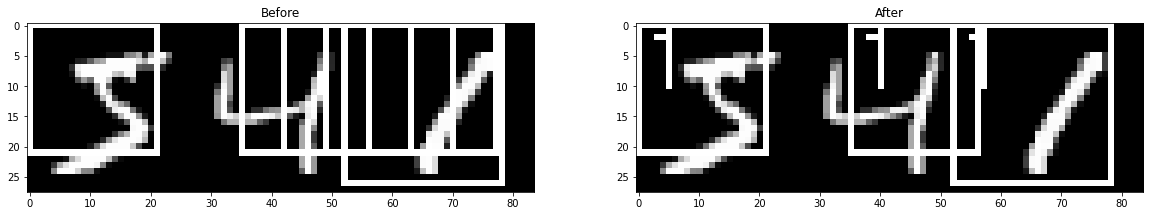

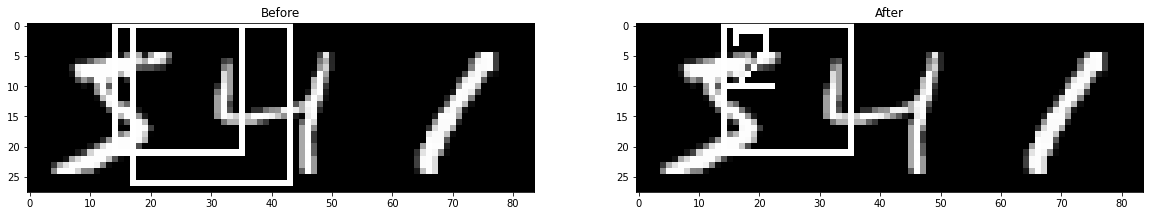

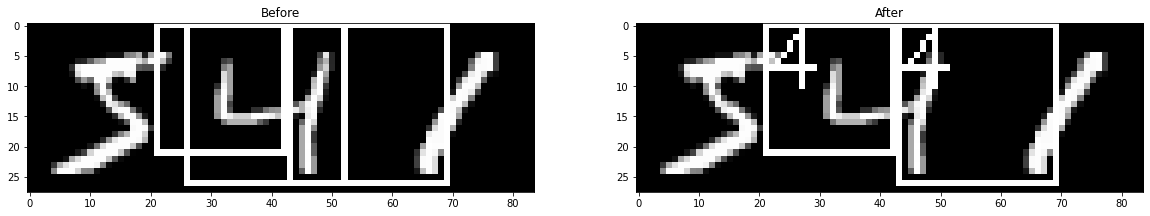

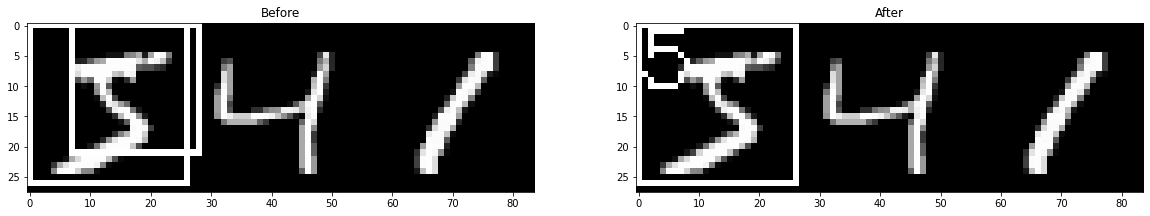

In [11]:
for label in sorted(labels.keys()):
    clone = orig.copy()
    fig, ax = plt.subplots(1, 2, figsize=(20, 6))
    for (box, prob) in labels[label]:
        (startX, startY, endX, endY) = box
        cv2.rectangle(clone, (startX, startY), (endX, endY), (255, 255, 255), 1)
    ax[0].imshow(clone, cmap='gray')
    ax[0].set_title("Before")
    clone = orig.copy()
    boxes = np.array([p[0] for p in labels[label]])
    proba = np.array([p[1] for p in labels[label]])
    boxes = non_max_suppression(boxes, proba)

    for (startX, startY, endX, endY) in boxes:
        cv2.rectangle(clone, (startX, startY), (endX, endY), (255, 255, 255), 1)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        cv2.putText(clone, str(label), (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 255, 255), 1)

    ax[1].imshow(clone, cmap='gray')
    ax[1].set_title("After")